<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Transfer%20Learning%20for%20Computer%20Vision/PyTorch_Transfer_Learning_Fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import os
import sys
from glob import glob

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

In [2]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2022-11-08 02:42:28--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  14.9MB/s    in 32s     

2022-11-08 02:43:01 (13.5 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
!unzip -qq -o Food-5K.zip

In [4]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [5]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

In [6]:
!mv Food-5K/* .

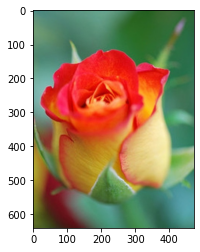

In [7]:
plt.imshow(imageio.imread('training/0_808.jpg'))
plt.show()

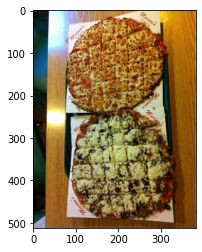

In [8]:
# Food images start with one, non-food images start with zero
plt.imshow(imageio.imread('training/1_616.jpg'))
plt.show()

In [9]:
!mkdir data

In [10]:
# make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [11]:
# move the images
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [12]:
transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

In [14]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
)

In [15]:
vgg = models.vgg16(pretrained=True)
vgg

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
class VGGFeatures(nn.Module):
    def __init__(self, vgg):
        super(VGGFeatures, self).__init__()
        self.vgg = vgg

    def forward(self, X):
        out = self.vgg.features(X)
        out = self.vgg.avgpool(out)
        out = out.view(out.size(0), -1)
        return out

In [17]:
vggf = VGGFeatures(vgg)

In [18]:
out = vggf(torch.rand(1,3,224,224))
out.shape

torch.Size([1, 25088])

In [19]:
Ntrain = train_dataset.__len__()
Ntest = test_dataset.__len__()
Ntrain, Ntest

(3000, 1000)

In [20]:
D = out.shape[1]

In [21]:
X_train = np.zeros((Ntrain, D))
y_train = np.zeros((Ntrain, 1))
X_test = np.zeros((Ntest, D))
y_test = np.zeros((Ntest, 1))

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
vggf.to(device)

cuda:0


VGGFeatures(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [23]:
i = 0
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
            
        output = vggf(inputs)
        
        sz = output.__len__()

        X_train[i:i + sz] = output.cpu().detach().numpy()
        y_train[i:i + sz] = targets.view(-1, 1).numpy()

        i += sz
        print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000


In [24]:
i = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
            
        output = vggf(inputs)
        
        sz = output.__len__()

        X_test[i:i + sz] = output.cpu().detach().numpy()
        y_test[i:i + sz] = targets.view(-1, 1).numpy()

        i += sz
        print(i)

128
256
384
512
640
768
896
1000


In [25]:
X_train.max(), X_train.min()

(61.94459533691406, 0.0)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.fit_transform(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, y_train.flatten())
print("train score:", logr.score(X_train2, y_train.flatten()))
print("test score:", logr.score(X_test2, y_test.flatten()))

train score: 1.0
test score: 0.986


In [28]:
model = nn.Linear(D, 1)

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


Linear(in_features=25088, out_features=1, bias=True)

In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [31]:
train_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train2.astype(np.float32)),
    torch.from_numpy(y_train.astype(np.float32))
)

test_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test2.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.float32))
)

In [32]:
batch_size = 128
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle=True) 
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2, batch_size=batch_size, shuffle=False)

In [33]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.datetime.now()
        train_loss = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.datetime.now() - t0
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Test Loss: {test_loss:.4f}, Duration: {dt}")
        
    return train_losses, test_losses

In [34]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader2, test_loader2, epochs=10)

Epoch 1/10, Train Loss: 0.1020,             Test Loss: 0.0418, Duration: 0:00:00.300245
Epoch 2/10, Train Loss: 0.0057,             Test Loss: 0.0376, Duration: 0:00:00.207988
Epoch 3/10, Train Loss: 0.0011,             Test Loss: 0.0356, Duration: 0:00:00.220857
Epoch 4/10, Train Loss: 0.0007,             Test Loss: 0.0353, Duration: 0:00:00.213443
Epoch 5/10, Train Loss: 0.0005,             Test Loss: 0.0350, Duration: 0:00:00.216046
Epoch 6/10, Train Loss: 0.0005,             Test Loss: 0.0349, Duration: 0:00:00.206400
Epoch 7/10, Train Loss: 0.0004,             Test Loss: 0.0349, Duration: 0:00:00.212050
Epoch 8/10, Train Loss: 0.0003,             Test Loss: 0.0350, Duration: 0:00:00.205825
Epoch 9/10, Train Loss: 0.0003,             Test Loss: 0.0350, Duration: 0:00:00.204753
Epoch 10/10, Train Loss: 0.0003,             Test Loss: 0.0350, Duration: 0:00:00.216554


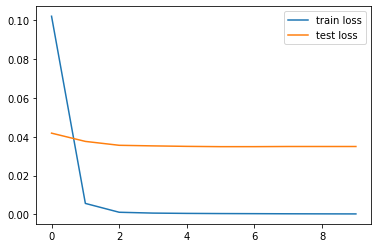

In [35]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [36]:
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader2:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.

for inputs, targets in test_loader2:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 63.4720, Test acc: 64.0000
